# Lecture 16: Dimensionality Reduction

- In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances.
- Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions.

> ...With just 100 features—significantly fewer than in the MNIST problem—all ranging from 0 to 1, you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were spread out uniformly across all dimensions

## Motivation: Projection

- In most real-world problems, training instances are not spread out uniformly across all dimensions
    - Many features are almost constant, while others are highly correlated
    - As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space

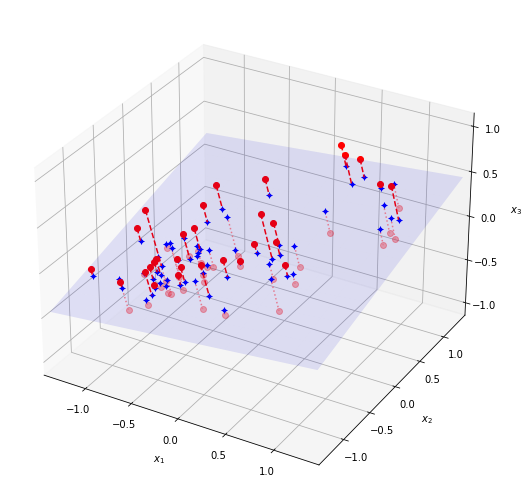

In [ ]:
# extra code

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit


import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
plt.show()

- See a 3D dataset represented by small spheres
    - all training instances lie close to a plane
    - this is a lower-dimensional (2D) subspace of the higher-dimensional (3D) space

- Project every training instance perpendicularly onto this subspace
    - as represented by the short dashed lines connecting the instances to the plane

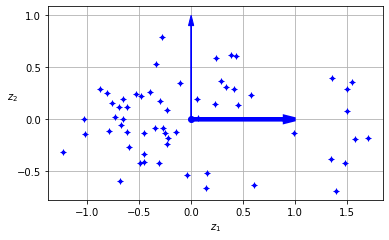

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

Note that the axes correspond to new features $z_1$ and $z_2$: they are the coordinates of the projections on the plane

## Principal component analysis

- Principal component analysis (PCA) is by far the most popular dimensionality reduction algorithm
    - First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it, just like above

### How can we choose the right hyper plane?

Consider a simple 2D dataset on the *left* in the following figure

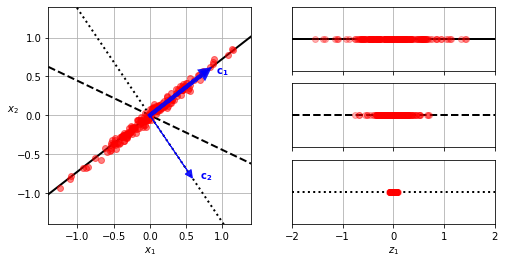

In [ ]:

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # stretch
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()
plt.show()

- See three difference axes
    - the projection onto the solid line preserves the maximum variance (top)
    - the projection onto the dotted line preserves very little variance (bottom)
    - the projection onto the dashed line preserves an intermediate amount of variance (middle)

**What line would you choose to project the data?** What does it mean?

It seems reasonable to select the axis that preserves **the maximum amount of variance**, as it will most likely **lose less information** than the other projections.

### Principal Components

PCA identifies the axis that accounts for the largest amount of variance in the training set

- The $i^{th}$ axis is called the $i^{th}$ principal component (PC) of the data
    - In the figure above, the first PC is the axis on which vector $c_1$ lies, and the second PC is the axis on which vector $c_2$ lies
    - In the first figure, the first two PCs are on the projection plane, and the third PC is the axis orthogonal to that plane
        - After the projection, first PC corresponds to the $z_1$ axis, and the second PC corresponds to the $z_2$ axis



- There is a standard matrix factorization technique called **singular value decomposition (SVD)**
  - $X=U \sum V^{T}$
  - $V$ contains the unit vectors that define all the principal components
        - Unit vectors are vectors whose magnitude is exactly 1 unit

In [ ]:
import numpy as np

np.random.seed(42)

m = 60
X = np.random.rand(m,3)
X_centered = X - X.mean(axis=0)
X_centered.shape

(60, 3)

In [ ]:
U, s, Vt = np.linalg.svd(X_centered)
print(Vt)
c1 = Vt[0]
c2 = Vt[1]

[[ 0.38286794  0.73424182 -0.56062562]
 [ 0.36992724 -0.67794196 -0.6352547 ]
 [ 0.8465022  -0.03582797  0.53117829]]


In [ ]:
print(c1)
print(c2)

[ 0.38286794  0.73424182 -0.56062562]
[ 0.36992724 -0.67794196 -0.6352547 ]


PCA assumes that the dataset is centered around the origin. As you will see, Scikit-Learn’s PCA classes take care of centering the data for you. If you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t forget to center the data first.

### Projecting Down to d Dimensions

- Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to **d** dimensions by projecting it onto the hyperplane defined by the first d principal components
- Selecting this hyperplane ensures that the projection will preserve as much variance as possible

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality $d$, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$
$$X_{d-proj}=X W_d$$


In [ ]:
W2 = Vt[:2].T
X2D = X_centered @ W2
print(X2D.shape)
print(X2D[:15])

(60, 2)
[[ 0.15291982 -0.49328163]
 [-0.0218512   0.49428973]
 [ 0.0430614  -0.46989409]
 [-0.53570326  0.10953794]
 [ 0.09452889  0.52618194]
 [-0.27874404  0.00593124]
 [-0.24196912  0.05136684]
 [-0.21563852  0.09850987]
 [ 0.36102214 -0.01273724]
 [ 0.32765891  0.23679628]
 [ 0.04318657  0.54551509]
 [ 0.34093778 -0.3394646 ]
 [-0.473416    0.08950415]
 [-0.29764224  0.24322359]
 [ 0.25758942 -0.29043892]]


### Using Scikit-Learn

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
X2D[:15]

array([[ 0.15291982,  0.49328163],
       [-0.0218512 , -0.49428973],
       [ 0.0430614 ,  0.46989409],
       [-0.53570326, -0.10953794],
       [ 0.09452889, -0.52618194],
       [-0.27874404, -0.00593124],
       [-0.24196912, -0.05136684],
       [-0.21563852, -0.09850987],
       [ 0.36102214,  0.01273724],
       [ 0.32765891, -0.23679628],
       [ 0.04318657, -0.54551509],
       [ 0.34093778,  0.3394646 ],
       [-0.473416  , -0.08950415],
       [-0.29764224, -0.24322359],
       [ 0.25758942,  0.29043892]])

In [ ]:
pca.components_

array([[ 0.38286794,  0.73424182, -0.56062562],
       [-0.36992724,  0.67794196,  0.6352547 ]])

### Explained Variance Ratio

The explained variance ratio indicates the proportion of the datset's variance that lies along each principal component

In [ ]:
pca.explained_variance_ratio_

array([0.42308306, 0.36146322])

- This output tells us that about 42% of the dataset’s variance lies along the first PC, and about 36% lies along the second PC. This leaves about 21% for the third PC
- It would not be surprising, given that the data set is just randomly generated.


### Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance—say, 95%

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [ ]:
pca = PCA()
pca.fit(X_train)

PCA()

In [ ]:
pca.explained_variance_ratio_.shape

(784,)

In [ ]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
cumsum[:20]

array([0.09704664, 0.16800588, 0.22969677, 0.28359097, 0.33227894,
       0.37540125, 0.40812055, 0.4369595 , 0.4645798 , 0.4881498 ,
       0.5092417 , 0.52947161, 0.54662979, 0.56355091, 0.57933732,
       0.59416685, 0.60741246, 0.62018143, 0.63205406, 0.6435809 ])

In [ ]:
d = np.argmax(cumsum >= 0.95) + 1

You could then set `n_components=d` and run PCA again, but there’s a better option.
Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

The actual number of components is determined during training, and it is stored in the `n_components_` attribute:

In [ ]:
pca.n_components_

154

In [ ]:
pca.explained_variance_ratio_.sum()

0.9501960192613034

- Yet another option is to plot the explained variance as a function of the number of dimensions
    - There will usually be an elbow in the curve, where the explained variance stops growing fast
    - In this case, you can see that reducing the dimensionality down to about 100 dimensions wouldn’t lose too much explained variance

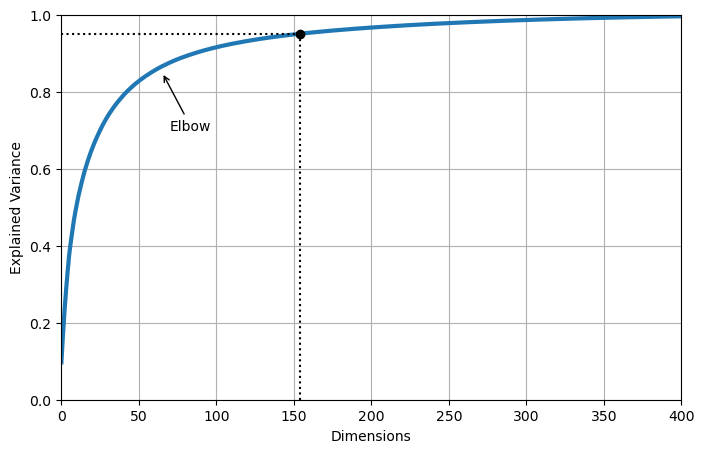

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()